In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform 
import plotly.express as px

### Import and EDA

In [2]:
#importing the file as a dataframe
df=pd.read_csv("Walmart_Store_sales.csv")

In [3]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage  and number of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage  and number of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

<AxesSubplot:>

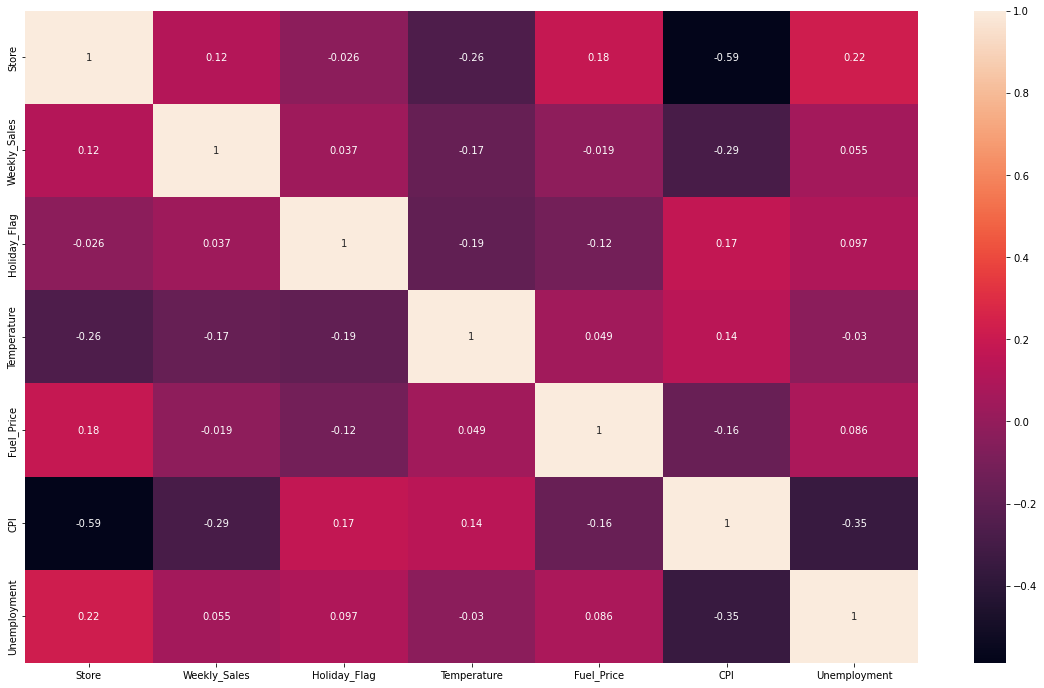

In [4]:
#looking at the correlation matrix
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True, ax=ax)

In [5]:
#looking at the numeric parameters with te biggest correlation to Weekly Sales (the target)
df.corr()["Weekly_Sales"].abs().sort_values(ascending=False)

Weekly_Sales    1.000000
CPI             0.287227
Temperature     0.165991
Store           0.115964
Unemployment    0.055191
Holiday_Flag    0.037037
Fuel_Price      0.019087
Name: Weekly_Sales, dtype: float64

In [6]:
#Remapping holiday flag to yes, no, or missing for ease of use
df['Holiday_Flag'] = df['Holiday_Flag'].map({0: 'No', 1: 'Yes'})
df['Holiday_Flag'].fillna("Missing",inplace=True)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,Missing,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,No,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,No,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,No,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,No,78.89,2.759,212.412888,7.092


In [7]:
#Dropping the null values for weekly sales as it is the target we want to predict
df.dropna(subset=["Weekly_Sales"],inplace=True)

In [8]:
#values of the target are spread, no obviou transformation to be done
fig = px.histogram(df, x="Weekly_Sales", nbins=len(df), title = "Distribution of target variable")
fig.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         136 non-null    float64
 1   Date          118 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  136 non-null    object 
 4   Temperature   121 non-null    float64
 5   Fuel_Price    124 non-null    float64
 6   CPI           125 non-null    float64
 7   Unemployment  122 non-null    float64
dtypes: float64(6), object(2)
memory usage: 9.6+ KB


In [10]:
#convert date to usable form, creating a column by type and then converting the date for graph purpose
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['dayoftheweek'] = pd.DatetimeIndex(df['Date']).weekday
df['Date']=pd.DatetimeIndex(df['Date'])

In [11]:
px.line(df.sort_values(by="Date"), x="Date", y="Weekly_Sales", color="Store", title="Sales over time by Store")
#We see a ratio of 1 to 5 in terms of sales, no significant seasonality but still fluctuation over time

In [12]:
#e now drop the date to avoid colinearity
df.drop("Date", axis=1, inplace=True)

In [13]:
px.scatter(df, x="CPI",y="Weekly_Sales", title="CPI")


In [14]:
px.scatter(df, x="Temperature",y="Weekly_Sales", title="Temperature")


In [15]:
px.scatter(df, x="Unemployment",y="Weekly_Sales", title="Temperature")

In [16]:
px.scatter(df, x="Fuel_Price",y="Weekly_Sales", title="Temperature")

In [17]:
#looking at how many null values are remaining
df.isnull().sum()

Store            0
Weekly_Sales     0
Holiday_Flag     0
Temperature     15
Fuel_Price      12
CPI             11
Unemployment    14
year            18
month           18
day             18
dayoftheweek    18
dtype: int64

In [18]:
#dropping the rows with less than 6 non NA values
df.dropna(thresh=6, inplace=True)

In [19]:
#looking at how many null values are remaining
df.isnull().sum()

Store            0
Weekly_Sales     0
Holiday_Flag     0
Temperature     14
Fuel_Price      12
CPI             10
Unemployment    12
year            16
month           16
day             16
dayoftheweek    16
dtype: int64

In [20]:
#in order to fill the missing values, we will convert all columns to numerical, and then use a KNNinputer to fill the remaining lines

#first, convert holiday flag to a yes and no column, and dropping missing as it is colinear with the other 2
cat_variables = df["Holiday_Flag"]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)
df2 = df.drop(['Holiday_Flag'], axis=1)
df2 = pd.concat([df2, cat_dummies], axis=1)
#and then using the KNN inputer. Store is still in a numeric format with no missing value so no problem
imputer = KNNImputer(n_neighbors=5)
df2 = pd.DataFrame(imputer.fit_transform(df2),columns = df2.columns)

In [21]:
df2.head()

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayoftheweek,No,Yes
0,6.0,1572117.54,59.610,3.0450,214.777523,6.858,2011.0,2.0,18.0,4.0,0.0,0.0
1,13.0,1807545.43,42.380,3.4350,128.616064,7.470,2011.0,3.0,25.0,4.0,1.0,0.0
2,11.0,1244390.03,84.570,3.3778,214.556497,7.346,2010.6,6.0,19.6,3.4,1.0,0.0
3,6.0,1644470.66,78.890,2.7590,212.412888,7.092,2010.0,5.0,28.0,4.0,1.0,0.0
4,4.0,1857533.70,56.402,2.7560,126.160226,7.896,2010.0,5.0,28.0,4.0,1.0,0.0


In [22]:
# summarize the number of rows with missing values for each column to check if the inputer worked fine
for i in df2.columns:
	n_miss = df2[i].isnull().sum()
	perc = n_miss / df2.shape[0] * 100
	print('> %s, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> Store, Missing: 0 (0.0%)
> Weekly_Sales, Missing: 0 (0.0%)
> Temperature, Missing: 0 (0.0%)
> Fuel_Price, Missing: 0 (0.0%)
> CPI, Missing: 0 (0.0%)
> Unemployment, Missing: 0 (0.0%)
> year, Missing: 0 (0.0%)
> month, Missing: 0 (0.0%)
> day, Missing: 0 (0.0%)
> dayoftheweek, Missing: 0 (0.0%)
> No, Missing: 0 (0.0%)
> Yes, Missing: 0 (0.0%)


In [23]:
df2["Fuel_Price"].count()

134

In [24]:
#creating a function to remove outliers
def outlierscleaning(df, listofcolumns):
    removed=0
    for cols in listofcolumns:
        #calculating IQR
        Q1 = df[cols].quantile(0.25)
        Q3 = df[cols].quantile(0.75)
        IQR = Q3 - Q1
        # counting outliers
        outliers = [x for x in df[cols] if x < (Q1 - 1.5 * IQR) or x > (Q3 + 1.5 * IQR)]
        print('In column {}, identified {} outliers, {} % of the values .'.format(cols,len(outliers),round(len(outliers)/df[cols].count()*100,2)))
        #removing outliers from df
        df = df.loc[((df[cols] > (Q1 - 1.5 * IQR)) & (df[cols] < (Q3 + 1.5 * IQR)))]
        removed+=len(outliers)
    print(f"Removed a total of {removed} lines")
    return df



In [25]:
#Run the cleaning function, checking we only remove a small part
df2= outlierscleaning(df2,["Temperature", "Fuel_Price", "CPI","Unemployment"])


In column Temperature, identified 0 outliers, 0.0 % of the values .
In column Fuel_Price, identified 0 outliers, 0.0 % of the values .
In column CPI, identified 0 outliers, 0.0 % of the values .
In column Unemployment, identified 5 outliers, 3.73 % of the values .
Removed a total of 5 lines


In [26]:
df2.describe(include="all")

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayoftheweek,No,Yes
count,129.000000,1.290000e+02,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,10.015504,1.268962e+06,61.057705,3.315389,179.494905,7.392211,2010.843411,6.733333,16.012403,3.722481,0.860465,0.062016
std,6.241224,6.565152e+05,17.319247,0.455252,38.931594,0.982930,0.780209,3.200423,8.258168,1.223292,0.347855,0.242124
min,1.000000,2.689290e+05,18.790000,2.514000,126.111903,5.143000,2010.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4.000000,5.978766e+05,47.420000,2.854000,132.763355,6.635000,2010.000000,4.000000,9.400000,4.000000,1.000000,0.000000
50%,9.000000,1.405007e+06,62.370000,3.422400,196.919506,7.368000,2011.000000,6.200000,16.000000,4.000000,1.000000,0.000000
75%,16.000000,1.811606e+06,75.170000,3.688000,214.896576,8.090000,2011.400000,9.000000,22.000000,4.000000,1.000000,0.000000
max,20.000000,2.771397e+06,91.650000,4.170000,226.968844,9.524000,2012.000000,12.000000,31.000000,6.000000,1.000000,1.000000


In [27]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'
Y = df2.loc[:,target_name]
X = df2.loc[:,[c for c in df2.columns if c!=target_name]] # All columns are kept, except the target


In [28]:

# First dividing between the train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Create pipeline for numeric features
numeric_features = [1,2,3,4,5,6,7,8,9,10] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())]) 
#we're scaling. No need for an inputer as there is no missing values

# Create pipeline for categorical features
categorical_features = ["Store"] # We want to use it as a category and not a number.
categorical_transformer = Pipeline(
    steps=[('encoder', OneHotEncoder(drop='first')) ])
     #encoding the column store. No need for an pinuter as we have no missing values
   
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)
# Preprocessings on test set
X_test = preprocessor.transform(X_test) 

In [29]:
# We Train our linear regression model
model = LinearRegression()
model.fit(X_train, Y_train) 
# Print scores
print("R2 on training set : ", model.score(X_train, Y_train))
print("R2 on test set : ", model.score(X_test, Y_test))
MEA=round(mean_absolute_error(Y_test, model.predict(X_test)))
moy=round(np.mean(Y_test))
print("Mean Absolute error is {}, mean is {}, error ratio is {}%".format(MEA,moy,round(MEA/moy*100,2)))


R2 on training set :  0.9661110760872086
R2 on test set :  0.9475889044674114
Mean Absolute error is 121158, mean is 1267103, error ratio is 9.56%


In [30]:
#converting the coefficients for the numeric features back to unscaled version
listcoefunscalled= np.true_divide(model.coef_[-10:],  preprocessor.transformers_[0][1].named_steps['scaler'].scale_)


In [31]:
#creating a dataframe of coefficients, scalled and unscalled, then sorting the absoute values
dfcoef=pd.DataFrame(data=model.coef_, index=list(preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names(categorical_features))+list(df2.iloc[:,2:].columns), columns=["CoefficientsScaled"] )
dfcoef["CoefficientsUnscalled"]=(np.concatenate([model.coef_[:18],listcoefunscalled], axis=0))
dfcoef.abs().sort_values(by="CoefficientsScaled", ascending=False)

,CoefficientsScaled,CoefficientsUnscalled
Store_16.0,1.375874e+06,1.375874e+06
Store_14.0,1.243058e+06,1.243058e+06
Store_20.0,1.207448e+06,1.207448e+06
month,1.115410e+06,3.457066e+05
Store_18.0,9.128274e+05,9.128274e+05
Store_19.0,8.813571e+05,8.813571e+05
year,6.918810e+05,8.862105e+05
Unemployment,6.869666e+05,6.947361e+05
day,6.857053e+05,8.284247e+04
Store_15.0,6.168144e+05,6.168144e+05


In [32]:
#We use a randomsearch to find the optimal parameter for a ridge model
regressor=Ridge()
params = {"alpha": uniform(loc=0, scale=1)}
randomsearch = RandomizedSearchCV(regressor, param_distributions=params, n_iter=2000, cv=10)
randomsearch.fit(X_train, Y_train)
print(randomsearch.best_params_)
print("R2 on training set : ", randomsearch.score(X_train, Y_train))
print("R2 on test set : ", randomsearch.score(X_test, Y_test))
MEA=round(mean_absolute_error(Y_test, randomsearch.predict(X_test)))
moy=round(np.mean(Y_test))
print("Mean Absolute error is {}, mean is {}, error ratio is {}%".format(MEA,moy,round(MEA/moy*100,2)))

{'alpha': 0.08459924853825862}
R2 on training set :  0.9650417696046838
R2 on test set :  0.9430950151522803
Mean Absolute error is 120148, mean is 1267103, error ratio is 9.48%


Using a ridge regression improve the model, but by a very small very margin. Both the R2 and the mea absolute error are better, but only by a very small margin. The obvious limit is the quantity of data, with only 129 lines we need more to get a better result

----

## Trying to add polynomail features to see if we can improve the model further

In [67]:
#reconstructing the pipeline

# Separate target variable Y from features X
target_name = 'Weekly_Sales'
Y = df2.loc[:,target_name]
X = df2.loc[:,[c for c in df2.columns if c!=target_name]] # All columns are kept, except the target
#converting Store to string as we want it as a category
X["Store"]=X["Store"].astype("string")

# dividing between the train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


#Select columns where type of data is numerical
query_cols1=X.select_dtypes(include=['number']).columns
#Get list of column indexes fitting previous test
numeric_features = [X.columns.get_loc(col) for col in query_cols1]
#we use polynomail features of rank 2 and a standard scaler
numeric_transformer = Pipeline(steps=[('poly', PolynomialFeatures()),('scaler', StandardScaler())]) 

#Select columns where type of data is categorical
query_cols2=X.select_dtypes(exclude=['number']).columns
#Get list of column indexes fitting previous test
categorical_features = [X.columns.get_loc(col) for col in query_cols2]
#one hot encoding for store
categorical_transformer = OneHotEncoder(drop='first')
   
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)
# Preprocessings on test set
X_test = preprocessor.transform(X_test) 

In [68]:
#We use a randomsearch to find the optimal parameter for an ElasticNet model (tu sue the L1 and L2 penalisation). It takes ~1min
regressor=ElasticNet()
params = {"alpha": uniform(loc=0, scale=1), "l1_ratio":uniform(loc=0, scale=1)}
randomsearch = RandomizedSearchCV(regressor, param_distributions=params, n_iter=1000, cv=10)
randomsearch.fit(X_train, Y_train)
print(randomsearch.best_params_)
print("R2 on training set : ", randomsearch.score(X_train, Y_train))
print("R2 on test set : ", randomsearch.score(X_test, Y_test))
MEA=round(mean_absolute_error(Y_test, randomsearch.predict(X_test)))
moy=round(np.mean(Y_test))
print("Mean Absolute error is {}, mean is {}, error ratio is {}%".format(MEA,moy,round(MEA/moy*100,2)))

c:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 811206695976.3037, tolerance: 4300939671.962024

c:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5183927716682.105, tolerance: 4004368837.050558

c:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6878254474961.662, tolerance: 3924590081.5929875

c:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6937492687379.285, toler

{'alpha': 0.023789753198926178, 'l1_ratio': 0.98309086414548}
R2 on training set :  0.9879664926960433
R2 on test set :  0.9073644233668746
Mean Absolute error is 143356, mean is 1269869, error ratio is 11.29%


c:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6129555448.498047, tolerance: 3977975567.586411

c:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8122735336.517578, tolerance: 4051619426.106722

c:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5149251746.689453, tolerance: 3969119839.1002965

c:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8671221377.566406, toler

In [69]:
X.shape

(129, 11)

In [70]:
X_train.shape

(103, 84)

R2 for test score is going down, we overfit too much. Looking at the shape of X_train, we now have 84 columns for 103 row, even with Lasso the model struggle with the limited quantity of data to get something not overfitting. Same conclusion as before, the limited number of row, especially once divided by Store, limit a lot the improvement we can reach